# Q-Learning Algorithms and their Application to Optimal Trading Problems:
## The Q-learning implementation

The goal of the algorithm: take a mean reverting strategy once you are at the bounds

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn, seed
import xarray as xr
import seaborn as sns 

In [2]:
%precision 4
%config InlineBackend.figure_format = "retina"

## The Ornstein-Uhlenbeck process

$$
    dS_{t+1} = \kappa(\bar S - S_t) + \sigma dW_t
$$

Where
* $\kappa$ is the force of the mean-reverting effect
* $\bar S$ is the mean-reverting value
* $\sigma$ is the *stardard* deviation of the process

In [3]:
# Going from (kappa, theta, sigma) -> (alpha, beta, gamma)
# does not seem to work properly (variance is way too low)
dt = 1 / 60
kappa, theta, sigma = 1e-5, 1, 2

alpha = theta * (1 - np.exp(-kappa * dt))
beta = np.exp(-kappa * dt)
gamma = np.sqrt(sigma ** 2 * (1 - np.exp(-2 * kappa * dt)) / (2 * kappa))

$$
    X_{t_i + 1} = \alpha + \beta X_{t_i}
$$

In [4]:
alpha, beta, gamma

(1.6666665281217519e-07, 0.9999998333333472, 0.25819886822283034)

In [5]:
timesteps = 500
t = np.linspace(0, 2, timesteps)

alpha, beta = .08, 0.98
gamma = .2
e_t = randn(timesteps) * gamma

In [6]:
seed(314)
x0 = 1.5
X = np.zeros(timesteps)
for t in range(timesteps):
    if t == 0:
        X[t] = x0
    else:
        X[t] = alpha + beta * X[t-1] + e_t[t-1]
X = X

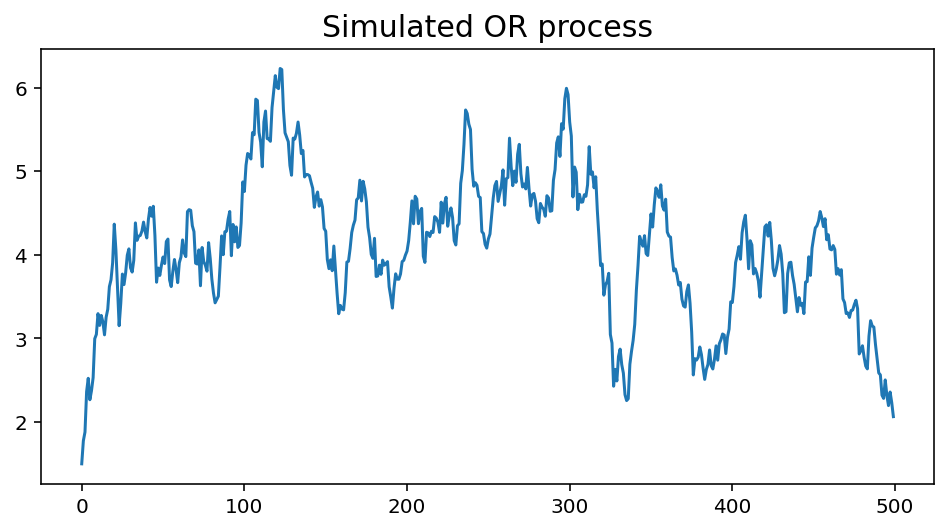

In [7]:
plt.figure(figsize=(8, 4))
plt.title("Simulated OR process", fontsize=15)
plt.plot(X);

We consider a three-tuple state that takes us to a single action

```
* T: terminal time (0, T)
* N: intermediate trading periods
* A: Number of shares traded at a single period
* Q: Current inventory
```

In [8]:
T, N, A, Q = 1, 1, 1, 1
Q = np.zeros((T, N, A, Q))

In [9]:
sigma = np.sqrt(2 * gamma ** 2 * np.log(beta) / (beta ** 2 - 1))
sigma

0.20202363756848574

In [10]:
n = 3.5
xmin, xmax = theta + np.array([-1, 1]) *  n * sigma / np.sqrt(2 * kappa)
xmin, xmax

(-157.10850533272006, 159.10850533272006)

In [11]:
# When we simulate our price path, we bin our observations
# into into intervals degined by the grid-points
M = 100
delta_x = (xmax - xmin) / M
bins = np.arange(M) * delta_x + xmin

## Implementation

In [12]:
def simulate_ou_process(x0, xbar, kappa, sigma, T, dt):
    time = np.arange(0, T, dt)
    nsteps = len(time)
    x = np.zeros(nsteps)
    x[0] = x0
    errs = randn(nsteps - 1)
    for t in range(nsteps - 1):
        x[t + 1] = x[t] + dt * (kappa * (xbar - x[t])) + np.sqrt(dt) * sigma * errs[t]
    
    return time, x

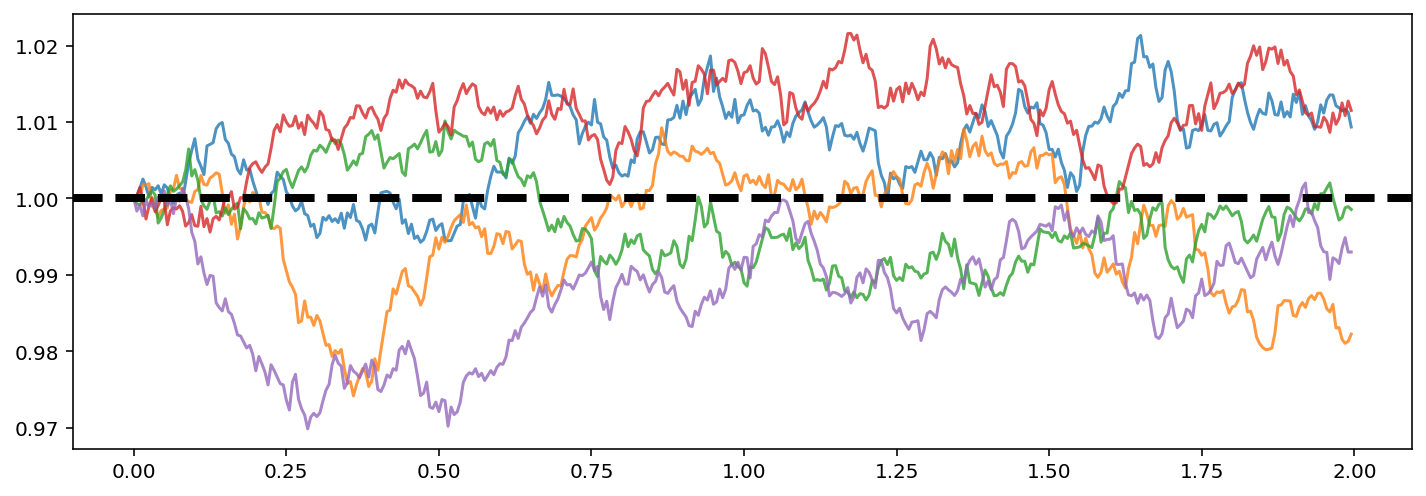

In [113]:
seed(314)
xbar = 1
plt.figure(figsize=(12, 4))
for _ in range(5):
    plt.plot(*simulate_ou_process(1, xbar, 1, 0.02, T=2, dt=0.005),
             alpha=0.8)
plt.axhline(y=xbar, linewidth=4, c="black", linestyle="--");

Reward at time $t_i$


$$
    R_i = q_{t_i} (X_{t_{i+1}} - X_{t_{i}}) - \phi a_{t_i}^2
$$

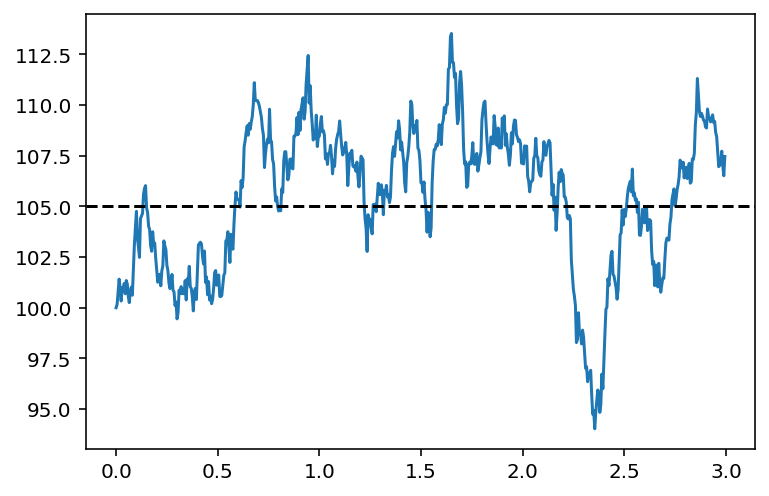

In [114]:
seed(314)
T, dt = 3, 0.005
x0, kappa, xbar, sigma = 100, 2, 105, 10
t, Xt = simulate_ou_process(x0, xbar, kappa, sigma, T, dt)
plt.plot(t, Xt)
plt.axhline(y=xbar, c="black", linestyle="--")

In [959]:
sell_min, buy_max = 5, 5
phi = 0.01
Qmin, Qmax = -10, 10
bucket_size = 0.5
xmin, xmax = 90, 115
prices = np.arange(xmin, xmax, 1)
inventory = np.arange(-50, 50)
actions = np.arange(-sell_min, buy_max)

In [960]:
prices = np.round(prices, 1)

Reward at time $t_i$


$$
    R_i = \mathbb{E}\left[(q_{t_i} + a_{t_i})  (X_{t_{i+1}} - X_{t_{i}}) - \phi a_{t_i}^2\right]
$$

In [963]:
Xt[1] - Xt[0]

-1.4000000000000057

In [964]:
def exploration_rate(C, D, k):
    return C / (D + k)

def learning_rate(A, B, k):
    return A / (B + k)

exploration_rate(50, 50, 0)

1.0000

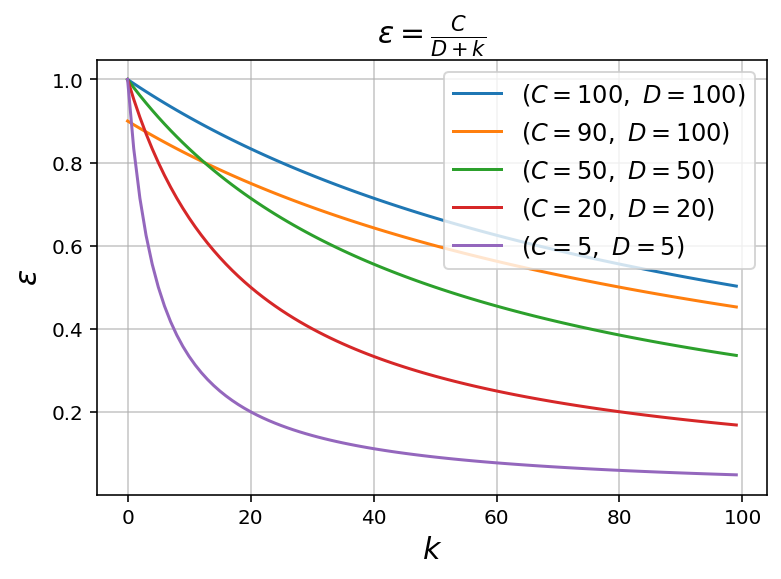

In [965]:
K = np.arange(100)
configurations = [(100, 100), (90, 100), (50, 50), (20, 20), (5, 5)]
for C, D in configurations:
    plt.plot(K, exploration_rate(C, D, K), label=rf"$(C={C}, \ D={D})$")
    plt.ylabel(r"$\epsilon$", fontsize=15)
    plt.xlabel(r"$k$", fontsize=15)
    plt.grid(alpha=0.7)
plt.title(r"$\epsilon = \frac{C}{D + k}$", fontsize=15)
plt.legend(fontsize=12);

Evidently $C \leq D$ for $\epsilon$ to be a valid probability.

In [966]:
np.set_printoptions(linewidth=110)

actions = np.arange(-sell_min, buy_max + 1, dtype=np.float32)
inventory = np.arange(Qmin, Qmax + 1, dtype=np.float32)
# Inventory X Purchase
action_space = actions[None, :] + inventory[:, None]
df_action = pd.DataFrame(action_space.copy(), columns=actions, index=inventory)

In [967]:
action_map = (Qmin <= action_space) & (action_space <= Qmax)
action_space[~action_map] = np.nan
action_space[action_map] = 1.

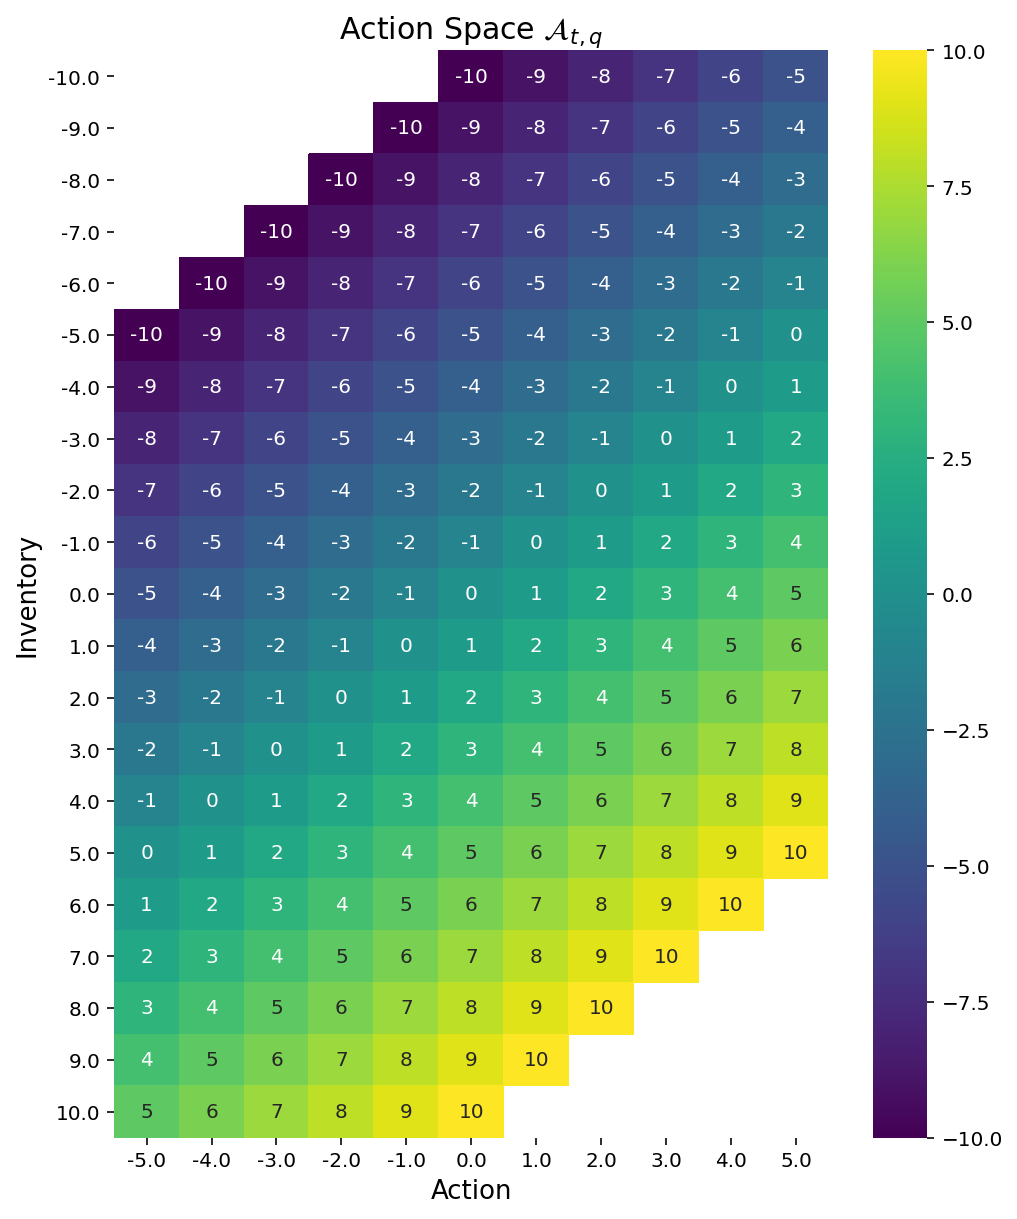

In [968]:
plt.figure(figsize=(8, 10))
plt.title(r"Action Space $\mathcal{A}_{t, q}$", fontsize=15)
sns.heatmap(df_action, annot=True, cmap="viridis", mask=~action_map)
plt.xlabel("Action", fontsize=13)
plt.ylabel("Inventory", fontsize=13);

In [969]:
phi, c = 0.01, 0.5

In [981]:
# ["time", "price", "inventory", "action"]
# Step 1: simulate the process
timesteps, Xt = simulate_ou_process(x0, xbar, kappa, sigma, T, dt)
timesteps = np.round(timesteps, 4)
Xt = Xt.round(0)
Xt = np.clip(Xt, xmin, prices.max())

R = np.diff(Xt)[:, None, None] * inventory[None, :, None] - phi * actions[None, None, :]
R[-1, :, :] = R[-1, :, :] - c * inventory[:, None]
R = R * action_space[None, :]

In [982]:
reward_dimensions = ["timestep", "inventory", "action"]
Rm = xr.DataArray(R, coords=[timesteps[1:], inventory, actions], dims=reward_dimensions)

In [983]:
n_actions = len(actions)
n_inventory = len(inventory)

In [984]:
# Initialize Q-matrix
Q = np.zeros((len(timesteps), len(prices), n_inventory, n_actions))
Q = action_space[None, None, :, :] * Q

In [985]:
dimensions = ["time", "price", "inventory", "action"]
Qm = xr.DataArray(Q, coords=[timesteps, prices, inventory, actions], dims=dimensions)

In [986]:
from tqdm.notebook import tqdm

In [987]:
Xt

array([100., 103., 105., 100., 100., 102., 111., 114., 113., 109., 112., 110., 102., 102., 103., 108., 114.,
       111., 109., 109., 108., 106., 103., 100., 100., 106., 109., 112., 114., 114.])

In [1015]:
k = 0
t, q = 0, 0
A, B, C, D = 50, 50, 100, 100
for ix, t in enumerate(timesteps[:-1]):
    # With probability epsilon select an action a
    # uniformly at random from Atq
    if rand() < exploration_rate(50, 50, k):
        possible_actions = df_action.loc[q]
        possible_actions = possible_actions[(Qmin <=  possible_actions) & (possible_actions <= Qmax)]
        new_action = possible_actions.sample().index[0]
    else:
        new_action = Qm.sel(time=t, inventory=q, price=Xt[ix])["action"].idxmax()

    q_prime  = q + new_action
    t_prime = (t + dt).round(3)

    reward = Rm.sel(timestep=t_prime, inventory=q_prime, action=new_action).values.max()
    alpha_k = learning_rate(A, B, k)

    selection_current = dict(time=t, inventory=q, price=Xt[0], action=new_action)
    selection_next = dict(time=t_prime, inventory=q_prime, price=Xt[ix + 1])
    Q_next = Qm.loc[selection_next].values.max()

    Q_update_value = (1 - alpha_k) * Qm.loc[selection_current] + alpha_k * (reward + gamma * Q_next)
    Qm.loc[selection_current] = Q_update_value

In [1016]:
possible_actions = df_action.loc[q]
possible_actions = possible_actions[(Qmin <=  possible_actions) & (possible_actions <= Qmax)]

## Dirty Work

In [1017]:
# Initialize Q-matrix
Q = np.zeros((len(timesteps), len(prices), n_inventory, n_actions))
#Q = action_space[None, None, :, :] * Q

In [1069]:
## Al together and dirty
A, B, C, D = 200, 200, 100, 100
dt = 0.1
dimensions = ["time", "price", "inventory", "action"]
Qm = xr.DataArray(Q.copy(), coords=[timesteps, prices, inventory, actions], dims=dimensions)

negatives, positives, nulls = 0, 0, 0
for k in tqdm(range(1000)):
    timesteps, Xt = simulate_ou_process(x0, xbar, kappa, sigma, T, dt)
    timesteps = np.round(timesteps, 4)
    Xt = Xt.round(0)
    Xt = np.clip(Xt, xmin, prices.max())

    R = np.diff(Xt)[:, None, None] * inventory[None, :, None] - phi * actions[None, None, :]
    R[-1, :, :] = R[-1, :, :] - c * inventory[:, None]
    Rm = xr.DataArray(R, coords=[timesteps[1:], inventory, actions], dims=reward_dimensions)
    t, q = 0, 0
    for ix, t in enumerate(timesteps[:-1]):
        # With probability epsilon select an action a
        # uniformly at random from Atq
        possible_actions = df_action.loc[q]
        possible_actions = possible_actions[(Qmin <=  possible_actions) & (possible_actions <= Qmax)]
        #if rand() < exploration_rate(C, D, k):
        if True:
            new_action = possible_actions.sample().index[0]
        else:
            new_action = (Qm.sel(time=t, inventory=q, price=Xt[ix],
                                 action=possible_actions.index)
                            .idxmax()
                            .values.max())

        q_prime  = q + new_action
        t_prime = (t + dt).round(3)
        
        if q_prime < 0:
            negatives += 1
        elif q_prime == 0:
            nulls += 1
        else:
            positives +=1
        print(f"{negatives:05}, {nulls:05}, {positives:05}", end="\r")

        reward = Rm.sel(timestep=t_prime, inventory=q_prime, action=new_action).values.max()
        alpha_k = learning_rate(A, B, k)

        selection_current = dict(time=t, inventory=q, price=Xt[ix], action=new_action)
        selection_next = dict(time=t_prime, inventory=q_prime, price=Xt[ix + 1])
        Q_next = Qm.loc[selection_next].values.max()

        Q_update_value = (1 - alpha_k) * Qm.loc[selection_current] + alpha_k * (reward + gamma * Q_next)
        Qm.loc[selection_current] = Q_update_value
        q = q_prime

13808, 01695, 13497


In [1061]:
Qm.time

<xarray.DataArray 'time' (time: 30)>
array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7,
       2.8, 2.9])
Coordinates:
  * time     (time) float64 0.0 0.1 0.2 0.3 0.4 0.5 ... 2.4 2.5 2.6 2.7 2.8 2.9

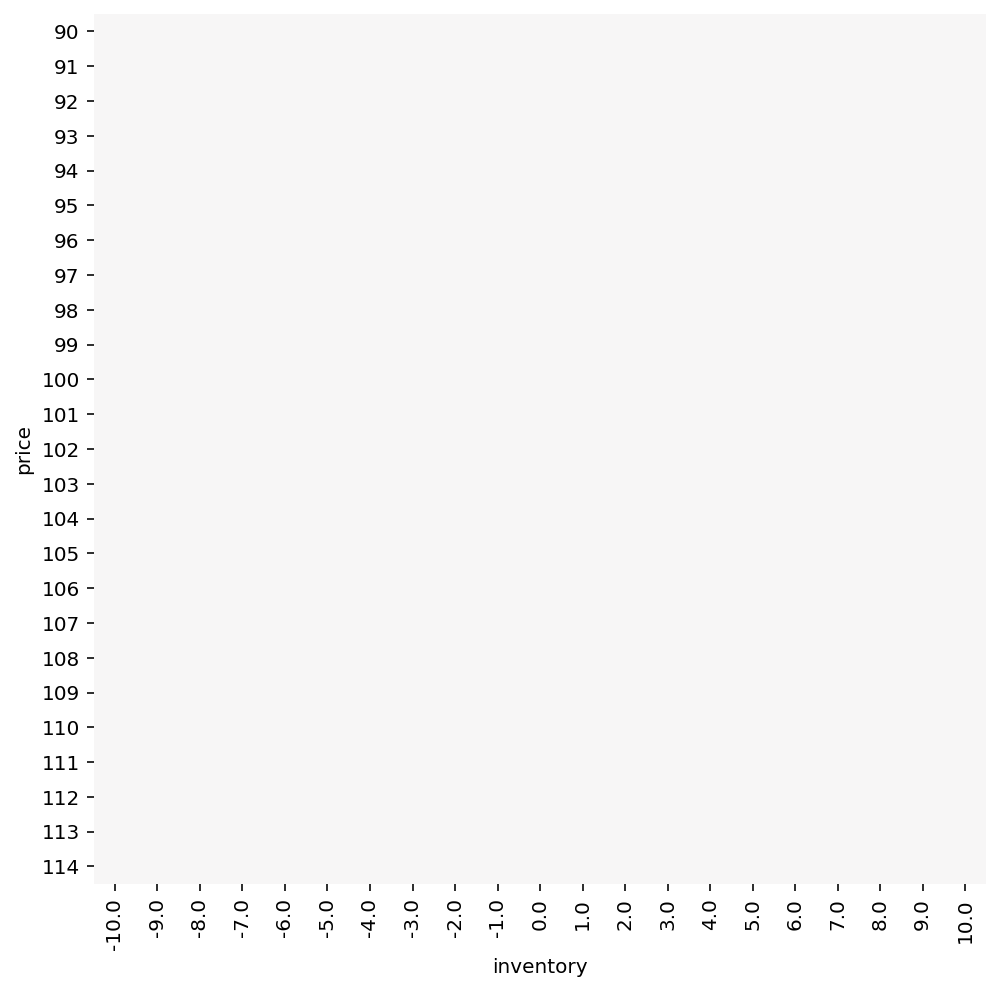

In [1083]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(8, 8))

nframes = 30
def animate(i):
    ax.cla()
    Qselect = Qm.isel(time=i).to_dataframe("Q").reset_index().pivot_table(index="price", columns="inventory", values="Q")
    sns.heatmap(Qselect, cmap="RdBu_r", vmin=-4, vmax=4, ax=ax, cbar=False)
    
ani = animation.FuncAnimation(fig, animate, frames=nframes,
                              interval=100)
ani.save("rl-ou.gif", writer="imagemagick")

<AxesSubplot:xlabel='inventory', ylabel='price'>

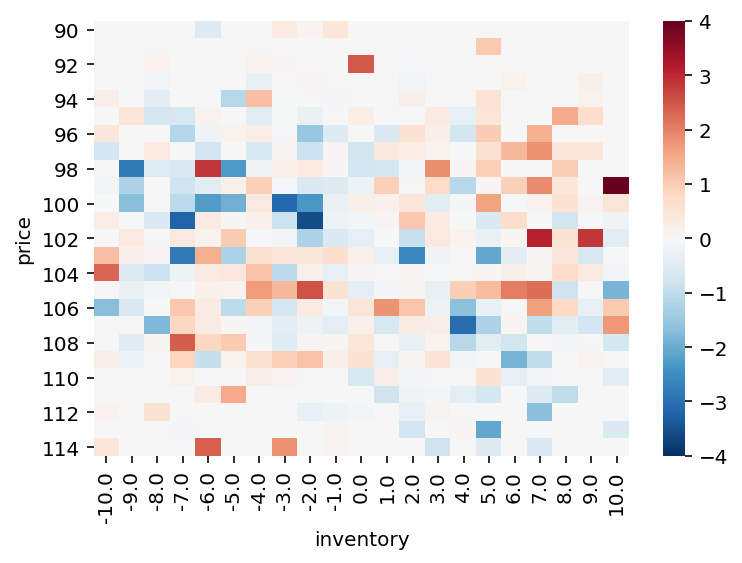

In [1070]:
sns.heatmap(Qm.sel(time=0.3).to_dataframe("Q").reset_index().pivot_table(index="price", columns="inventory", values="Q"), cmap="RdBu_r", vmin=-4, vmax=4)

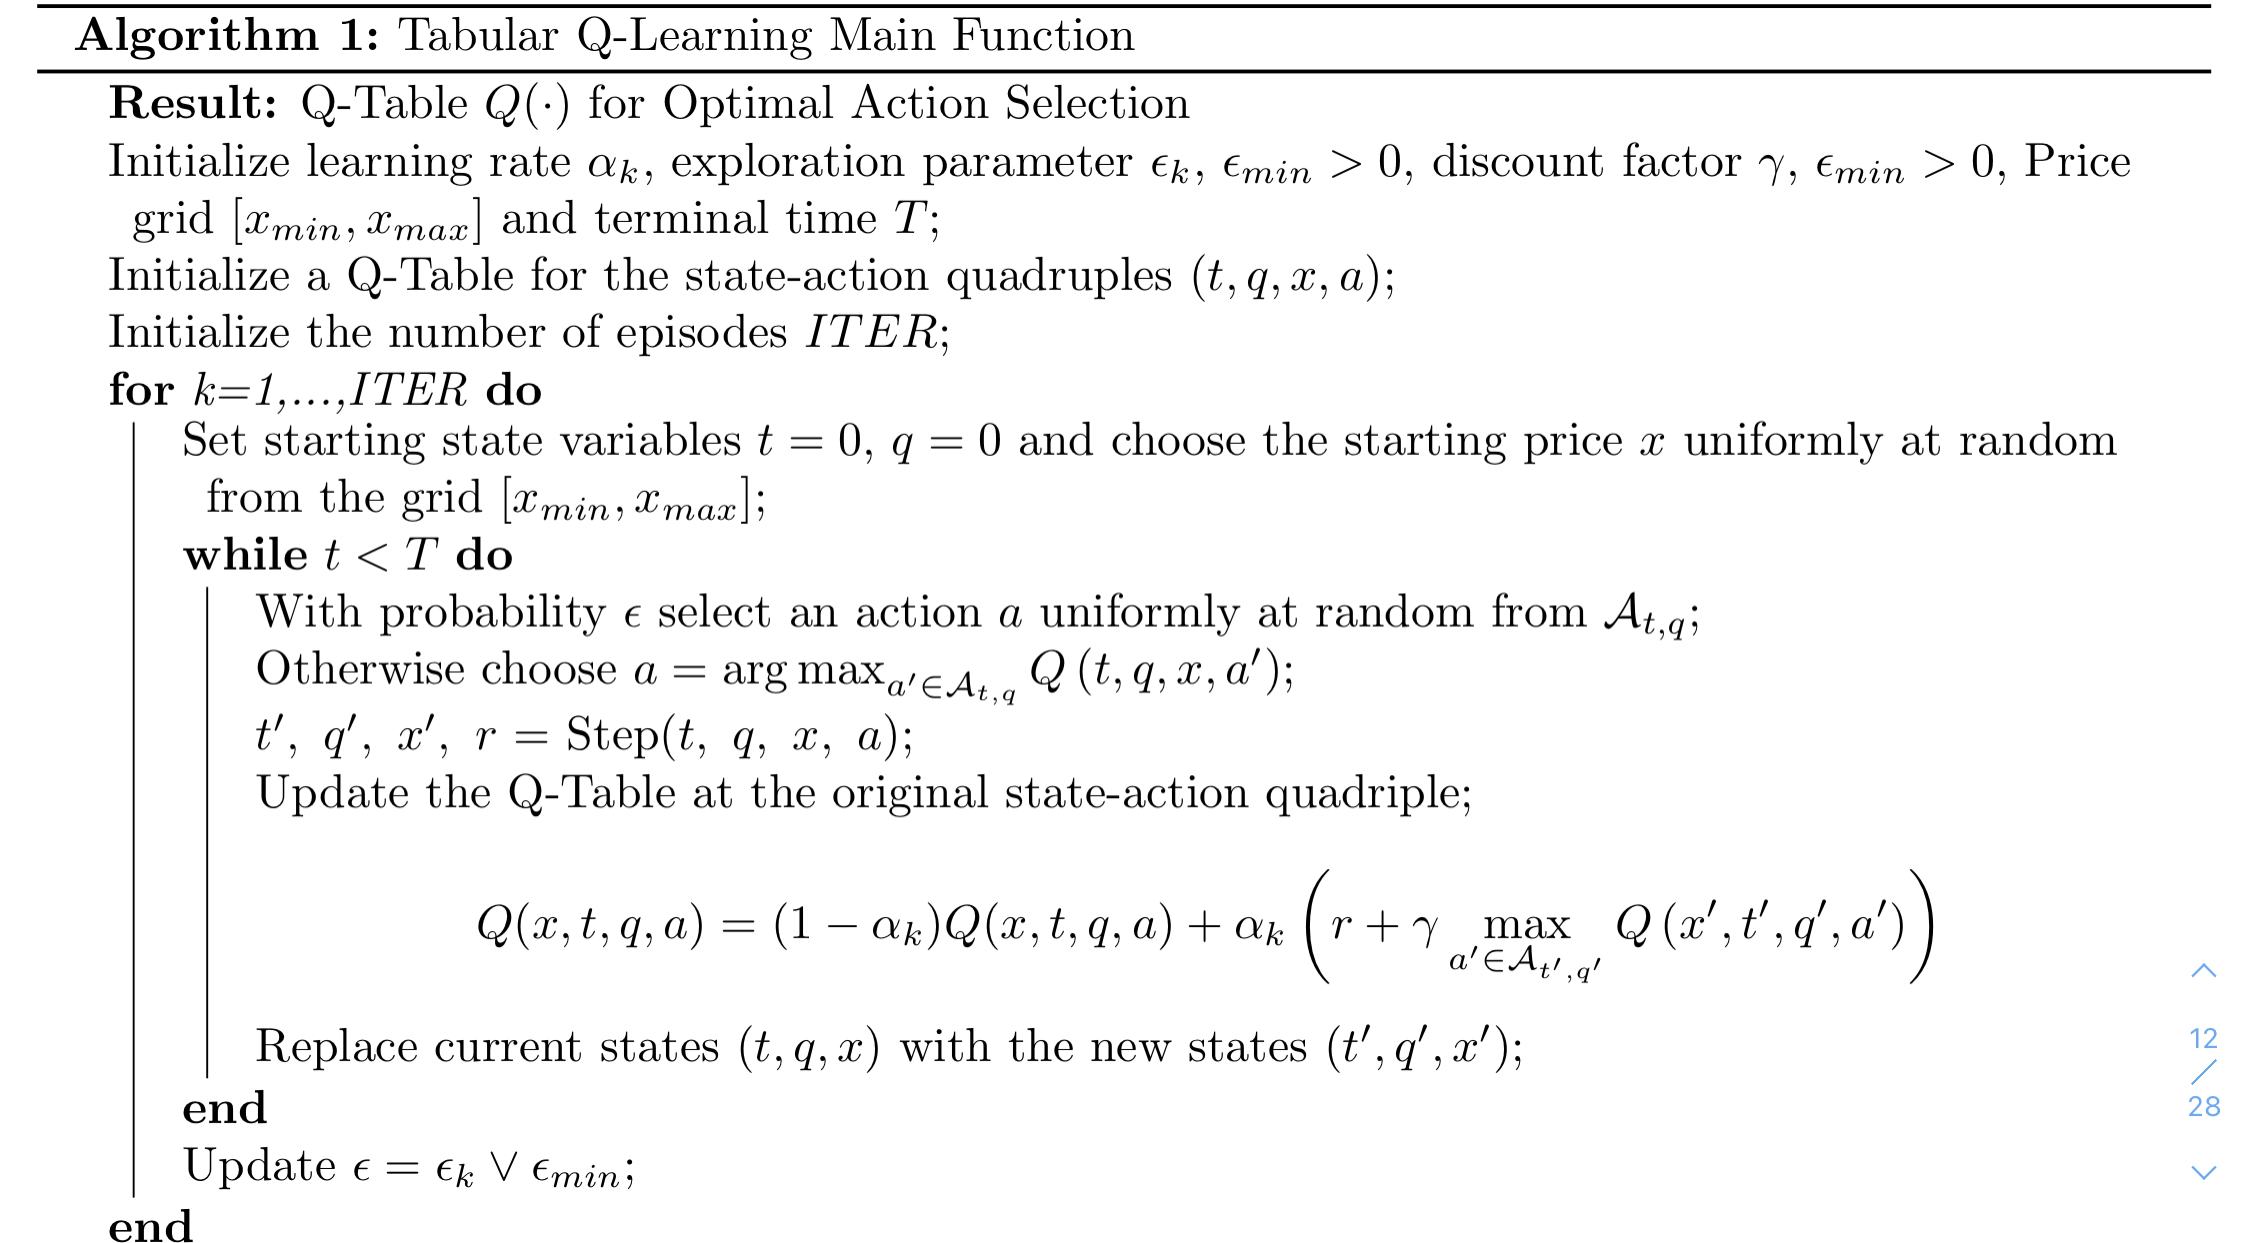

In [19]:
class QTrading:
    def __init__(self, kappa, sigma, xbar, phi, gamma=0.2, T=1, dt=0.01):
        self.kappa = kappa
        self.sigma = sigma
        self.xbar = xbar
        self.phi = phi
        self.gamma = gamma
        self.T = T
        self.dt = dt
        
    def next_price(self, price):
        discount_factor = np.exp(-self.kappa * self.dt)
        Z_2sigma = self.sigma ** 2 / (2 * self.kappa) * (1 - discount_factor ** 2)
        Z = np.sqrt(Z_2sigma) * randn()
        price = price * discount_factor + self.xbar * (1 - discount_factor) + Z

        return price
        
    def step(self, time, inventory, price, action):
        q_new = inventory + action
        new_price = self.next_price(price)
        t_new = time + self.dt
        if t_new < self.T:
            r = q_new * (new_price - price) - self.phi * action ** 2
        else:
            r = q_new * (new_price - price) - self.phi * action ** 2 - c * q_new** 2
        
        new_price = np.round(new_price, 1)
        return r, t_new, q_new, new_price

In [20]:
qtrading = QTrading(kappa=1, sigma=4, xbar=100, phi=.01)

In [21]:
learning_rate = 0.01
discount_factor = 0.8

In [24]:
reward_new, t_new, inventory_new, price_new = qtrading.step(0, 0, 100, 10)
Q_new_max = Q.sel(price=price_new, time=0.01, inventory=inventory_new).max().values

target_entry = {
    "time": 0,
    "price": 100,
    "inventory": 0,
    "action": 0
}

Q_update = ((1 - learning_rate) * Q.sel(target_entry) +
         learning_rate * (reward_new + discount_factor * Q_new_max))

In [25]:
Q.loc[target_entry] = Q_update.values

Q.sel(target_entry)

<xarray.DataArray ()>
array(-0.032)
Coordinates:
    time       float64 0.0
    price      float64 100.0
    inventory  int64 0
    action     int64 0